In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
import numpy as np
import sys

In [2]:
voc_dir="../Berkeleydata"

In [3]:
def read_voc_images(root=voc_dir, is_train=True):
    txt_fname = '%s/txtfile/3400/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = image.imread('%s/Images/%s.jpg' % (root, fname))
        labels[i] = image.imread(
            '%s/ImagesPNG/%s.png' % (root, fname))
    return features, labels

train_features, train_labels = read_voc_images()

[(256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (256, 256, 3)]

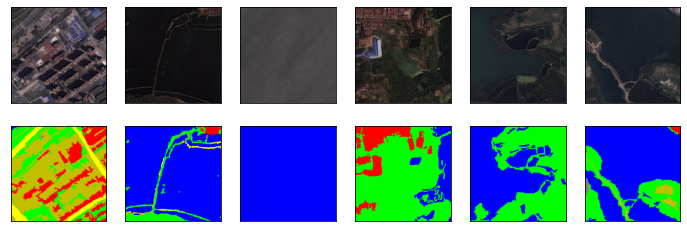

In [4]:
n = 6
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);
[im.shape for im in imgs]

In [5]:

VOC_COLORMAP = [[169,169,169], [255,0,0], [153,153,0], [255,255,0],
                [0,255,0], [0,0,255]]

VOC_CLASSES = ['baresoil', 'building', 'pavement', 'road', 'vegetation',
               'water']

In [6]:
colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i


def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [7]:
y = voc_label_indices(train_labels[0], colormap2label)
y[0:10, 0:10], VOC_CLASSES[4]

(
 [[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 0. 0.]
  [5. 5. 5. 5. 5. 5. 5. 5. 4. 4.]]
 <NDArray 10x10 @cpu(0)>,
 'vegetation')

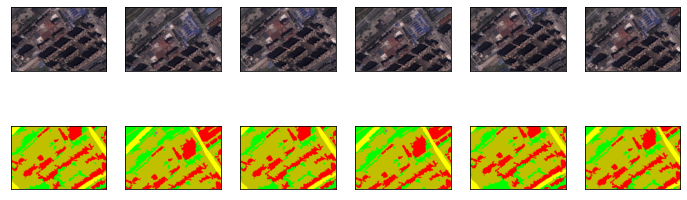

In [8]:

def voc_rand_crop(feature, label, height, width):
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)#change
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [9]:

class VOCSegDataset(gdata.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label):
        self.rgb_mean = nd.array([0.485, 0.456, 0.406])
        self.rgb_std = nd.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose((2, 0, 1)),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [10]:
crop_size = (160, 160)#change1
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label)

read 3400 examples
read 1002 examples


In [11]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(voc_train, batch_size, shuffle=True,
                              last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(voc_test, batch_size, last_batch='discard',
                             num_workers=num_workers)

In [12]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 160, 160)
(64, 160, 160)


In [13]:
X = nd.arange(1, 17).reshape((1, 1, 4, 4))
K = nd.arange(1, 10).reshape((1, 1, 3, 3))
conv = nn.Conv2D(channels=1, kernel_size=3)
conv.initialize(init.Constant(K))
conv(X), K

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>,
 
 [[[[1. 2. 3.]
    [4. 5. 6.]
    [7. 8. 9.]]]]
 <NDArray 1x1x3x3 @cpu(0)>)

In [14]:
W, k = nd.zeros((4, 16)), nd.zeros(11)
k[:3], k[4:7], k[8:] = K[0, 0, 0, :], K[0, 0, 1, :], K[0, 0, 2, :]
W[0, 0:11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k
nd.dot(W, X.reshape(16)).reshape((1, 1, 2, 2)), W

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>,
 
 [[1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0. 0.]
  [0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0.]
  [0. 0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9.]]
 <NDArray 4x16 @cpu(0)>)

In [15]:
conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv.initialize()

X = nd.random.uniform(shape=(1, 3, 64, 64))
Y = conv(X)
Y.shape

(1, 10, 32, 32)

In [16]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize()
conv_trans(Y).shape

(1, 3, 64, 64)

In [17]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output

(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
   (3): Flatten
 ),
 Dense(512 -> 1000, linear))

In [18]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

In [19]:
X = nd.random.uniform(shape=(1, 3, 160, 160))#change2
net(X).shape

(1, 512, 5, 5)

In [20]:
num_classes = 21
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,
                           strides=32))

In [21]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

In [22]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

In [23]:
img = image.imread('../Berkeleydata/Fig2_2019.jpeg')
X = img.astype('float32').transpose((2, 0, 1)).expand_dims(axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose((1, 2, 0))

input image shape: (287, 512, 3)
output image shape: (574, 1024, 3)


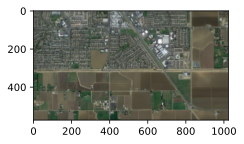

In [24]:
d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.asnumpy());

In [25]:
net[-1].initialize(init.Constant(bilinear_kernel(num_classes, num_classes,
                                                 64)))
net[-2].initialize(init=init.Xavier())

In [26]:
crop_size, batch_size, colormap2label = (160, 160), 32, nd.zeros(256**3)#change3
for i, cm in enumerate(VOC_COLORMAP):
    colormap2label[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
voc_dir = '../Berkeleydata'

num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(
    VOCSegDataset(True, crop_size, voc_dir, colormap2label), batch_size,
    shuffle=True, last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(
    VOCSegDataset(False, crop_size, voc_dir, colormap2label), batch_size,
    last_batch='discard', num_workers=num_workers)

read 3400 examples
read 1002 examples


In [27]:
for i in range(3):
    i=float(i+1)
    ctx = d2l.try_all_gpus()
    loss = gloss.SoftmaxCrossEntropyLoss(axis=1)
    net.collect_params().reset_ctx(ctx)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1**i,
                                                      'wd': 1e-3})
    d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=5)

training on [gpu(0)]
epoch 1, loss 1.3454, train acc 0.622, test acc 0.728, time 29.0 sec
epoch 2, loss 0.7364, train acc 0.712, test acc 0.728, time 26.3 sec
epoch 3, loss 0.6738, train acc 0.731, test acc 0.732, time 26.3 sec
epoch 4, loss 0.6443, train acc 0.740, test acc 0.760, time 26.3 sec
epoch 5, loss 0.6185, train acc 0.748, test acc 0.767, time 26.3 sec
training on [gpu(0)]
epoch 1, loss 0.5918, train acc 0.759, test acc 0.772, time 26.4 sec
epoch 2, loss 0.5939, train acc 0.758, test acc 0.770, time 26.3 sec
epoch 3, loss 0.5905, train acc 0.759, test acc 0.771, time 26.3 sec
epoch 4, loss 0.5857, train acc 0.760, test acc 0.773, time 26.4 sec
epoch 5, loss 0.5837, train acc 0.761, test acc 0.773, time 26.3 sec
training on [gpu(0)]
epoch 1, loss 0.5927, train acc 0.758, test acc 0.771, time 26.4 sec
epoch 2, loss 0.5869, train acc 0.761, test acc 0.773, time 26.5 sec
epoch 3, loss 0.5902, train acc 0.760, test acc 0.772, time 26.4 sec
epoch 4, loss 0.5827, train acc 0.761, t

In [28]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = X.transpose((2, 0, 1)).expand_dims(axis=0)
    pred = nd.argmax(net(X.as_in_context(ctx[0])), axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

In [29]:
def label2image(pred):
    colormap = nd.array(VOC_COLORMAP, ctx=ctx[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

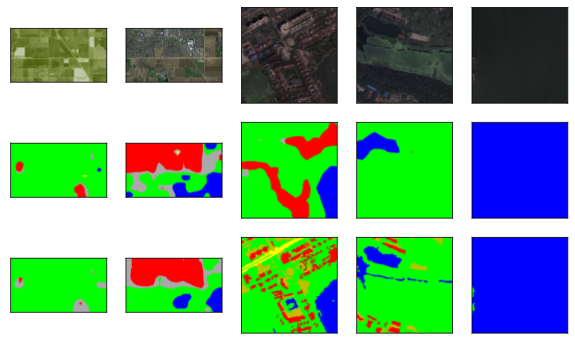

In [30]:
test_images, test_labels = read_voc_images(is_train=False)
n, imgs = 5, []
for i in range(n):
    crop_rect = (0, 0, 512, 512)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n);

In [31]:
d2l.plt.imsave('../Berkeleydata/Predict/pred1.png', imgs[1].asnumpy())

In [32]:
d2l.plt.imsave('../Berkeleydata/Predict/pred2.png', imgs[4].asnumpy())